# Quantum State Transfer in Coupled Cavity Arrays

##### Amelia Broman

Summer 2020

Physics Department, University of California Davis

Research mentors: Dr. Richard Scalettar and Dr. Marina Radulaski

In [1]:
import numpy as np
from numpy import linalg as LA

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

## Functions to generate data

In [2]:
def construct_states_helper(n, m, e_list, arr, state_list, index, tot):
    """Recursively constructs all possible states of a system.
    Parameters: n, the number of cavities.  m, the number of photons.
    e_list, list with elements specifying number of emitters in each cavity.
    arr, a list of length n that we edit to construct a state.
    state_list, a running list of states we've found.
    index, the current index in arr that we're editing.
    tot, the sum of numbers currently placed in arr."""
    
    #base case (state found)
    if tot==m:
        state_list.append(arr.copy()) #make copy so list entry doesn't change when we change arr
        return 
    
    if index in e_inds:
        var_range = 2  #emitters can be 0 or 1
    else:
        var_range = m+1-tot  #photon range narrows as tot approaches m 
    
    #loop over possible values
    for val in range(var_range):  
        arr[index] = val  #place value at index
        new_arr = arr.copy()  #make copy to edit in downwards recursion
        if (index < len(arr)-1 or tot+val==m):  #ensures that we don't go out of index range
            construct_states_helper(n, m, e_list, new_arr, state_list, index+1, tot+val) 
        
    
def construct_states(n, m, e_list):
    """Runs construct_states_helper.
    Parameters:  n, the number of cavities.  m, the number of photons.
    e_list, list with elements specifying number of emitters in each cavity.
    Returns: state_list, an ordered list of basis states."""
    global e_inds, photon_inds
    
    state_list = []
    arr = [0]*(n+sum(e_list))  #array to store state
    
    #find indices of the emitters in arr
    e_inds = []
    count = 0
    for cavity in range(n):  #loop thru cavities
        count+=1  #photon ind
        for i in range(e_list[cavity]):
            e_inds.append(count)  #append emitter index
            count+=1
            
    #all other indices are photon indices
    photon_inds = []
    for i in range(len(arr)):
        if i not in e_inds:
            photon_inds.append(i)
    
    construct_states_helper(n, m, e_list, arr, state_list, index=0, tot=0) 
    
    return state_list
    
def construct_h(n, m, e_list, j_list=None, g_list=None, wc_list=None, we_list=None, PBC = False):
    """Constructs Hamiltonian for cavity system.  
    Parameters: n, the number of cavities.  m, the number of photons. 
    e_list, list with elements specifying number of emitters in each cavity.
    j, the intercavity coupling.  g, the atom-cavity coupling.
    wc, energy cost of photon.  we, energy cost of emitter.
    PBC, toggle for periodic boundary conditions.
    Returns: h, the Hamiltonian."""
    global state_list, num_photons_list, num_emitters_list
    
    #import data from previous function
    state_list = construct_states(n, m, e_list)[::-1]  #reverse order of states because recursive ordering is "backwards"
    num_states = len(state_list)
    
    if j_list is None:
        j_list = [1]*(n-1)  #set each intercavity coupling J
    if g_list is None:
        g_list = [1]*len(e_inds)  #set each cavity coupling G
    if wc_list is None:
        wc_list = [0]*n  #set each omega_c
    if we_list is None:
        we_list = [0]*len(e_inds)  #set each omega_e
    
    #create version of state_list whose elements are tuples (to use as dictionary keys -- lists can't be keys)
    state_tuples = []
    for state in state_list:
        state_tuples.append(tuple(state))
    
    #create dictionary where keys are states, values are index of that state
    dict_keys = state_tuples
    dict_vals = np.linspace(0, num_states-1, num_states)
    state_dict = dict(zip(dict_keys, dict_vals))
    
    h = np.zeros([num_states, num_states])
    
    #initialize lists to be used in calculating <N_p> and <N_e> later
    num_photons_list = []
    num_emitters_list = []
    
    #find all possible transformations, enter them in Hamiltonian
    for pos in range(len(state_list)):  #loop over all states in state_list
        state = state_list[pos]
        
        #initialize counts for number operator
        num_photons = 0
        num_emitters = 0
        number_operator = 0
        
        for ind in range(len(state)):  #loop over photon/emitter numbers within state
            
            #at photon index
            if ind not in e_inds:  
                photon_ind = ind #store cavity's photon index 
                
                if state[ind] > 0:  #if photon(s) in cavity
                    num_photons += state[ind]
                    number_operator += wc_list[photon_inds.index(ind)]*state[ind]  #add the cavity's wc times number of photons in cavity
                    
                    #hop to left
                    if (ind != 0 or PBC == True):  #exclude leftmost site when PBC is false
                        left_neighbor = photon_inds[photon_inds.index(ind)-1]  
                        new_state = state.copy()  #create list to represent new state after hop
                        new_state[ind] -= 1
                        new_state[left_neighbor] += 1
                        pos_new = state_dict[tuple(new_state)]  #find index of new state
                        h[pos, int(pos_new)] = -j_list[photon_inds.index(ind)-1]*np.sqrt(state[ind] * (state[left_neighbor]+1))  #insert energy term at appropriate site

                    #hop to right
                    #exclude rightmost site when PBC is false
                    #skip when N=2 and PBC is true, since right hop is then same as left hop
                    if (photon_inds.index(ind) != len(photon_inds)-1 or (PBC == True and n!=2)):  
                        right_neighbor = photon_inds[(photon_inds.index(ind)+1) %len(photon_inds)]  #mod for PBC
                        new_state = state.copy()
                        new_state[ind] -= 1
                        new_state[right_neighbor] += 1
                        pos_new = state_dict[tuple(new_state)]
                        h[pos, int(pos_new)] = -j_list[photon_inds.index(ind)]*np.sqrt(state[ind] * (state[right_neighbor]+1))

                    #excitation
                    emitter_ind = ind+1
                    while emitter_ind in e_inds:  #loop over all emitters in cavity
                        if state[emitter_ind] == 0:  #emitter in ground state
                            new_state = state.copy()
                            new_state[ind] -= 1
                            new_state[emitter_ind] += 1
                            pos_new = state_dict[tuple(new_state)]  
                            h[pos, int(pos_new)] = g_list[e_inds.index(emitter_ind)]*np.sqrt(state[ind])
                        emitter_ind += 1
                    
            #at emitter index
            elif ind in e_inds:  #deexcitation
                if state[ind] == 1:  #emitter in excited state
                    num_emitters += 1
                    number_operator += we_list[e_inds.index(ind)]  #add the emitter's we
                    
                    new_state = state.copy()
                    new_state[ind] -= 1
                    new_state[photon_ind] += 1
                    pos_new = state_dict[tuple(new_state)]  
                    h[pos, int(pos_new)] = g_list[e_inds.index(ind)]*np.sqrt(state[photon_ind]+1)
        
        #insert number operator on diagonal
        h[pos, pos] = number_operator
            
        #record how many photons and emitters are in this state
        num_photons_list.append(num_photons)
        num_emitters_list.append(num_emitters)
                
    return h


## Time Evolution Functions

In [3]:
def construct_u(wh, vh, t):
    """Constructs the unitary evolution operator U.
    Parameter: wh and vh, eigenvalues and eigenvectors of H.
    t, the duration of time evolution."""
    s = vh  #matrix with eigenvectors as columns
    s_inv = LA.inv(s)  #inverse of s
    u_diag = np.zeros([len(wh), len(wh)], dtype=np.complex)  
    for ind in range(len(wh)):
        u_diag[ind][ind] = np.exp(-1j*wh[ind]*t) 
    u_qubit = LA.multi_dot([s, u_diag, s_inv])
    return u_qubit

def time_evolve_step(wh, vh, psi_0, t):
    """Performs time evolution of a wavefunction.
    Parameters: wh and vh, the eigenvalues and eigenvectors of H.  
    psi_0, the initial wavefunction.
    t, the duration of time evolution."""
    u = construct_u(wh, vh, t)
    psi_t = np.dot(u, psi_0)
    return psi_t

def time_evolve(h, psi_0, num_steps=200, dt=0.1):
    """Performs time evolution of wavefunction over a number of steps.
    Parameters: n, number of cavities.  m, number of excitations. e_list, list of locations of emitters.  
    psi_0, the original wavefunction.  num_steps, the number of iterations.  dt, the step size."""
    global wh, vh
    
    wh, vh = LA.eigh(h)
    
    t_list = np.zeros(num_steps)  #list to store times
    prob_list = np.zeros((num_steps, len(psi_0)))  #list to store probabilities for states over time
    
    for step in range(num_steps):
        t_list[step] = step*dt
        psi_t = time_evolve_step(wh, vh, psi_0, step*dt)  #time evolve
        
        #record probabilities of being in each state
        for cmpnt in range(len(psi_t)):
            state_prob = np.dot(psi_t[cmpnt].conj(), psi_t[cmpnt])
            prob_list[step][cmpnt] = np.real(state_prob)
    
    return (t_list, prob_list)


## Plotting Functions

In [4]:
def time_evolve_colorplot(prob_list, fig_size = (12,8), tick_width = 8, patch=True, ends=False):
    """Plot probabilities of being in each state over time using a colormap.
    Parameters: prob_list, a 2D list of probabilities for each state over time."""
    fig = plt.figure(figsize=fig_size)
    plt.imshow(prob_list.T, extent=[0, num_steps*dt,0, len(state_list)], aspect="auto")
    cb = plt.colorbar()
    cb.set_label("Probability", size=20, labelpad=-75)
    cb.ax.tick_params(labelsize=16) 
    
    plt.xlabel("Time",fontsize=20)
    plt.tick_params("x", labelsize=16)
    
    plt.ylabel("Location in Chain", fontsize=20)
    plt.tick_params("y", labelsize=16)
    tick_locs = np.array(range(len(state_list))) + 0.5
    yticks = plt.yticks(tick_locs, [])
    
    if patch == True:
        plt.tick_params("y", length=10, width=tick_width)
        if ends == False:
            for i in range(len(state_list)):
                if i in photon_inds:
                    yticks[0][-1-i].get_children()[0].set_color("red")
                else:
                    yticks[0][-1-i].get_children()[0].set_color("blue")
        else:
            for i in range(len(state_list)):
                if i == 0 or i == len(state_list)-1:
                    yticks[0][-1-i].get_children()[0].set_color("blue")
                else:
                    yticks[0][-1-i].get_children()[0].set_color("red")
            
    
        red_patch = mpatches.Patch(color='red', label='Photon')
        blue_patch = mpatches.Patch(color='blue', label='Emitter')
        plt.legend(handles=[red_patch, blue_patch], fontsize=14)
    else:
        plt.tick_params("y", length=0)
        
        
def time_evolve_lineplot(t_list, prob_list, Rabi=False, fig_size = (10,6)):
    fig = plt.figure(figsize=fig_size)
    
    #points_list = []
    #max_list = []
    for state in range(len(state_list)):  #plot probability vs. time for each state
        if state == photon_inds[-1] or state in e_inds:
            plt.plot(t_list, prob_list[:, state], "o-", label=state_list[state])
            prob_max = prob_list[:, state].max()
            prob_max_ind = list(prob_list[:, state]).index(prob_max)
    
    if Rabi == True:
        omega = wh[-1] - wh[0]  #Rabi frequency = highest eval - lowest eval
        ys = (np.cos(omega*t_list/2))**2  #Rabi oscillation
        plt.plot(t_list, ys, label="Rabi Oscillation")
        
    plt.xlabel("Time", fontsize=16)
    plt.ylabel("Occupation Probablity", fontsize=16)
    

## State Transfer by engineering J

#### Engineering each J (Christandl paper)

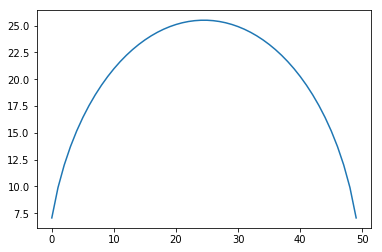

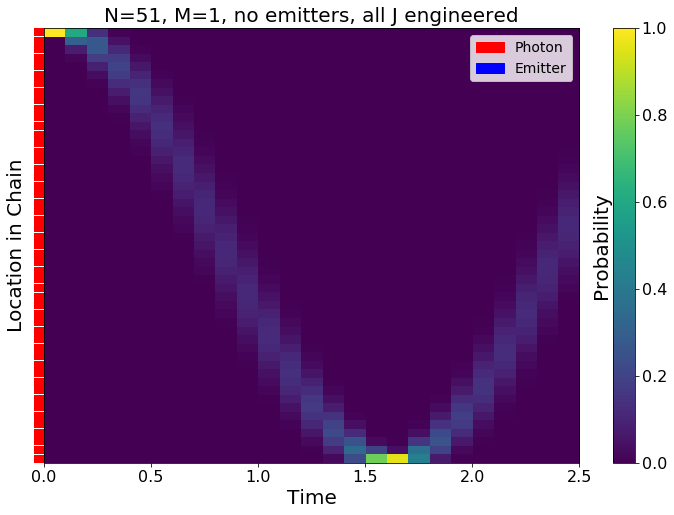

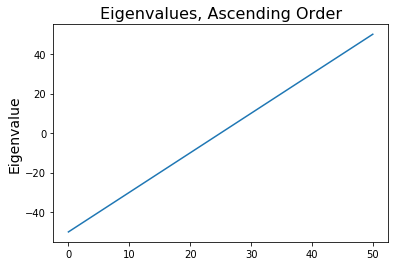

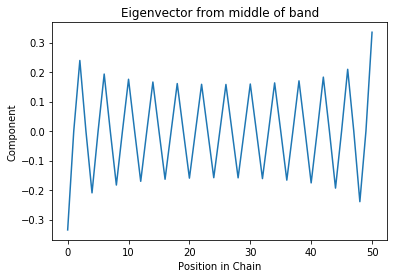

In [10]:
n=51
num_steps = 25
dt = 0.1
psi_0 = [0]*n
psi_0[0]=1

j_list = []
for i in range(1, n):
    j_list.append(np.sqrt(i*(n-i)))
plt.plot(j_list)

h = construct_h(n, m=1, e_list=[0]*n, j_list=j_list)
t_list, prob_list = time_evolve(h, psi_0, num_steps)

time_evolve_colorplot(prob_list, fig_size=(12,8))
plt.title("N=51, M=1, no emitters, all J engineered", fontsize=20)

fig = plt.figure()
plt.plot(wh)
plt.ylabel("Eigenvalue", fontsize=14)
plt.title("Eigenvalues, Ascending Order", fontsize=16)

fig = plt.figure()
plt.plot(vh[:,25])
plt.xlabel("Position in Chain")
plt.ylabel("Component")
plt.title("Eigenvector from middle of band");

#### Changing one J value at each end (Zwick paper)

Text(0.5,1,'Eigenvector from middle of chain')

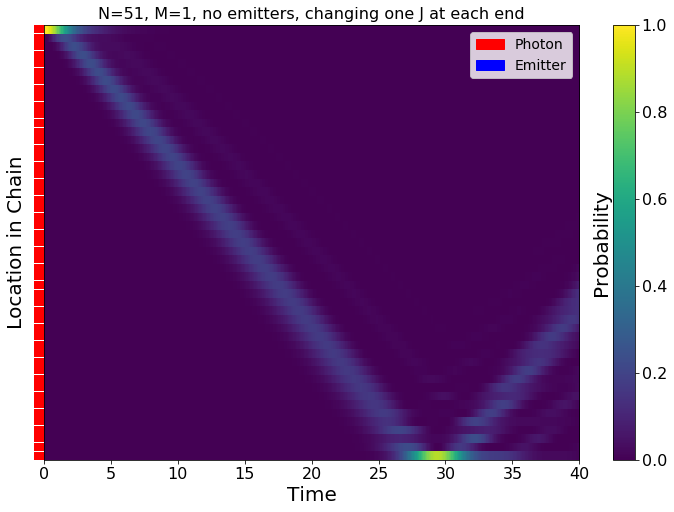

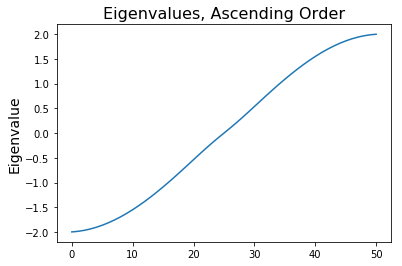

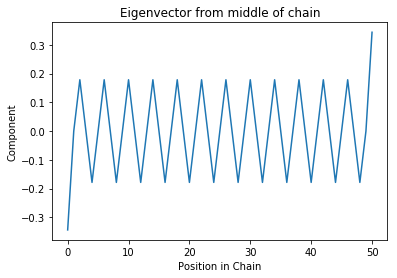

In [11]:
n=51
num_steps = 400
dt = 0.1
psi_0 = [0]*n
psi_0[0]=1

j_list = [1]*(n-1)
j_list[0] = n**(-1/6)  #proportionality formula from Zwick paper
j_list[-1] = n**(-1/6)

h = construct_h(n, m=1, e_list=[0]*n, j_list=j_list)
t_list, prob_list = time_evolve(h, psi_0, num_steps)

time_evolve_colorplot(prob_list)
plt.title("N=51, M=1, no emitters, changing one J at each end", fontsize=16)

fig = plt.figure()
plt.plot(wh)
plt.ylabel("Eigenvalue", fontsize=14)
plt.title("Eigenvalues, Ascending Order", fontsize=16)

fig = plt.figure()
plt.plot(vh[:,25])
plt.xlabel("Position in Chain")
plt.ylabel("Component")
plt.title("Eigenvector from middle of chain");

#### Changing two J values at each end (Apollaro paper)

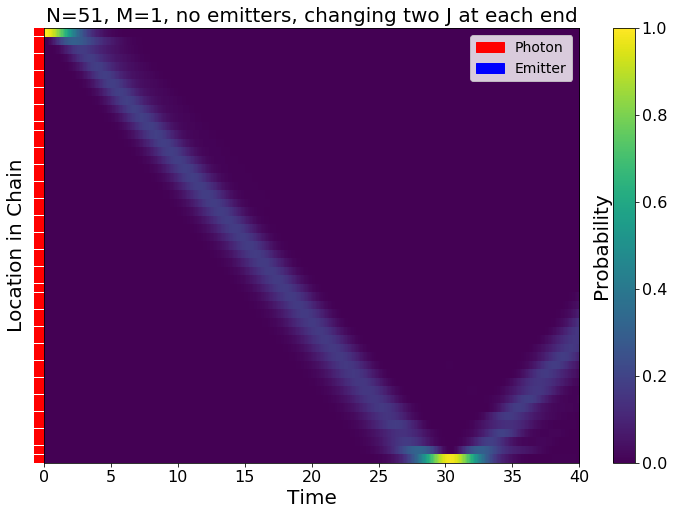

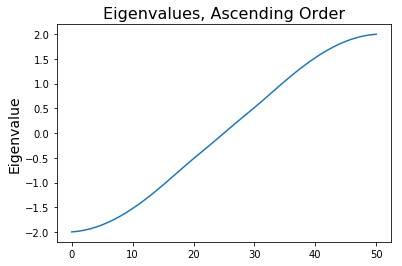

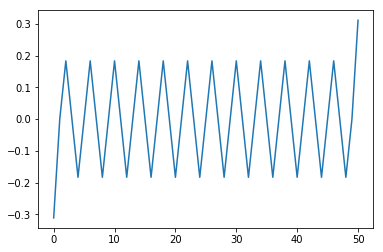

In [12]:
n=51
num_steps = 400
dt = 0.1
psi_0 = [0]*n
psi_0[0]=1

j_list = [1]*(n-1)
j_list[0] = .4322  #optimal values for n=51 from Apollaro paper
j_list[-1] = .4322
j_list[1] = .7338
j_list[-2] = .7338

h = construct_h(n, m=1, e_list=[0]*n, j_list=j_list)
t_list, prob_list = time_evolve(h, psi_0, num_steps)

time_evolve_colorplot(prob_list)
plt.title("N=51, M=1, no emitters, changing two J at each end", fontsize=20)

fig = plt.figure()
plt.plot(wh)
plt.ylabel("Eigenvalue", fontsize=14)
plt.title("Eigenvalues, Ascending Order", fontsize=16)

fig = plt.figure()
plt.plot(vh[:,25]);

### Comparison of defect J at ends vs. emitters at ends

#### Defect J at ends:

0.9002640565593026


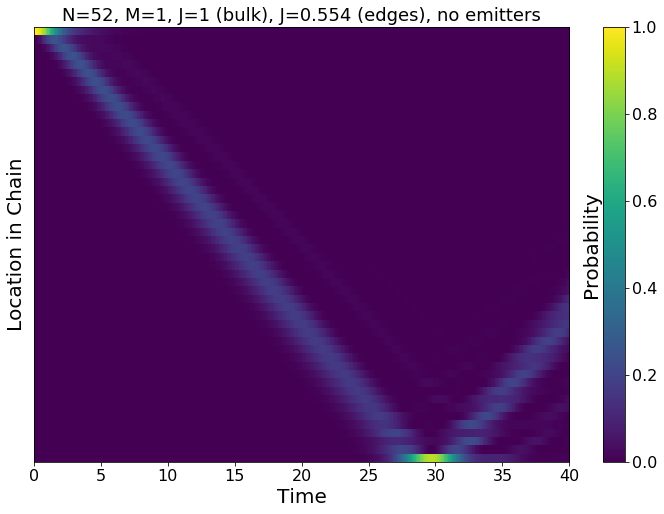

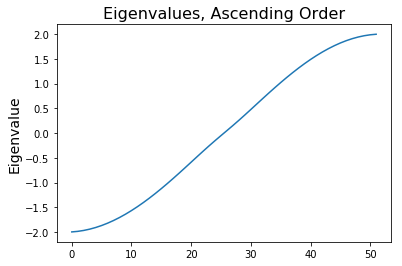

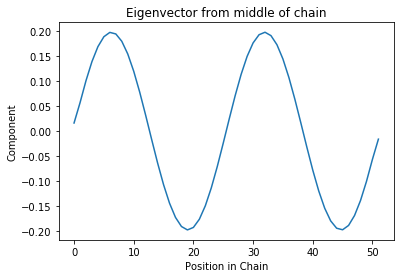

In [43]:
#defect J, no emitters

n=52
num_steps = 400
dt = 0.1
psi_0 = [0]*n
psi_0[0]=1

j_list = [1]*(n-1)
j_list[0] = 0.554  #recommended in Banchi paper for N=51
j_list[-1] = 0.554

h = construct_h(n, m=1, e_list=[0]*n, j_list=j_list)
t_list, prob_list = time_evolve(h, psi_0, num_steps)
print(np.amax(prob_list[100:]))

time_evolve_colorplot(prob_list, tick_width=6, patch=False)
plt.title("N=52, M=1, J=1 (bulk), J=0.554 (edges), no emitters", fontsize=18)

fig = plt.figure()
plt.plot(wh)
plt.ylabel("Eigenvalue", fontsize=14)
plt.title("Eigenvalues, Ascending Order", fontsize=16)

fig = plt.figure()
plt.plot(vh[:,3])
plt.xlabel("Position in Chain")
plt.ylabel("Component")
plt.title("Eigenvector from middle of chain");

wh_couplings = wh;
vh_couplings = vh;
h_couplings = h;

#### Emitters at ends:

0.9002640565593011


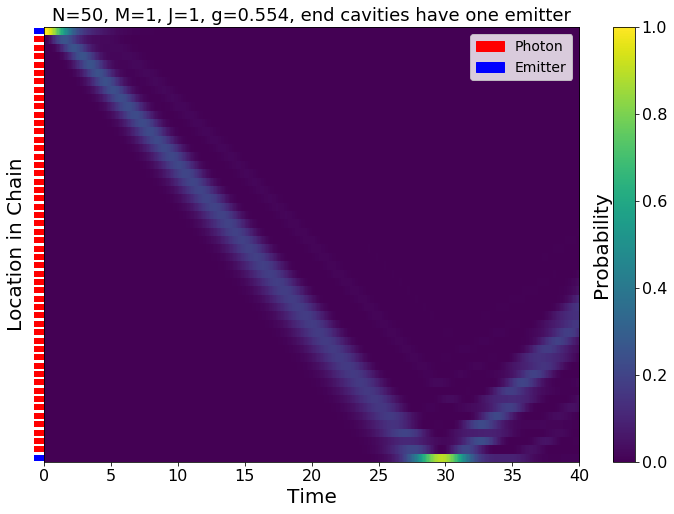

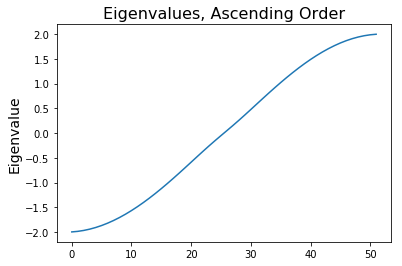

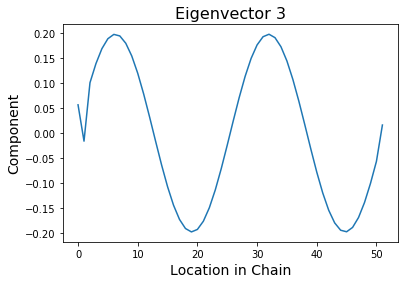

In [44]:
#emitters in end cavities

n=50
m=1
num_steps = 400
dt = 0.1

e_list = [0]*n
e_list[0] = e_list[-1] = 1

j_list = [1]*(n-1)  
g_list = [0.554]*len(e_list)

psi_0 = [0]*(n + np.sum(e_list))
psi_0[1]=1
 
h = construct_h(n, m, e_list=e_list, j_list=j_list, g_list=g_list)
t_list, prob_list = time_evolve(h, psi_0, num_steps, dt)

print(np.amax(prob_list[100:]))

prob_list[:, [1, 0]] = prob_list[:, [0, 1]]

time_evolve_colorplot(prob_list, tick_width=6, ends=True)
plt.title("N=50, M=1, J=1, g=0.554, end cavities have one emitter", fontsize=18)

fig = plt.figure()
plt.plot(wh)
plt.ylabel("Eigenvalue", fontsize=14)
plt.title("Eigenvalues, Ascending Order", fontsize=16);

ev = 3
fig = plt.figure()
plt.plot(vh[:,ev])
plt.ylabel("Component", fontsize=14)
plt.xlabel("Location in Chain", fontsize=14)
plt.title("Eigenvector {}".format(ev), fontsize=16);

wh_emitter = wh;
vh_emitter = vh;
h_emitter = h;

Above, we see that the system with N=52 and defect J at each end is equivalent to the system with N=50 and an emitter in each end cavity, under the condition that the defect J' = g.  The printed value is the maximum probability of the excitation appearing at the opposite end of the array.  This value is the same for both systems, indicating that they have identical (and good!) quantum state transfer.  This effect is true in general, for an emitter-in-end-cavities CCA of length N and a defect J array of length N+2.  Their Hamiltonians are similar matrices (they would be identical except for the opposite signs of J and g in the Tavis-Cummings-Hubbard model), and so they have identical eigenvalues and thus identical time evolution.  They are basically analogous systems. 

This is a key result.

### No emitters, uniform J

0.4159158621043394


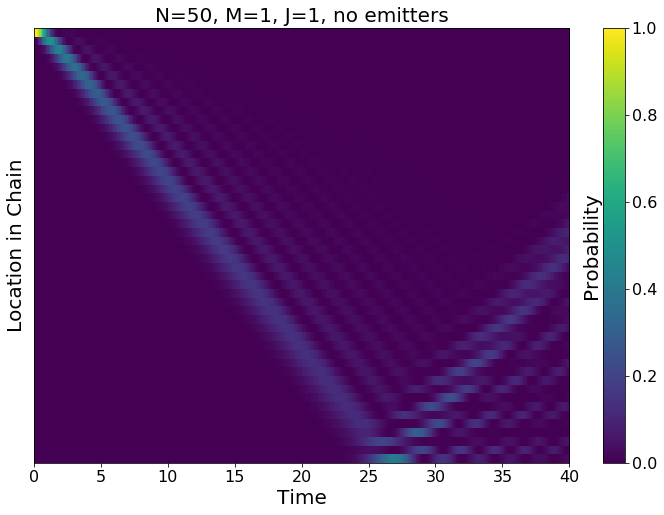

In [15]:
#no emitters, uniform J

n=50
m=1
num_steps = 400
dt = 0.1

e_list = [0]*n
j_list = [1]*(n-1)    

psi_0 = [0]*(n + np.sum(e_list))
psi_0[0]=1
 
h = construct_h(n, m, e_list=e_list, j_list=j_list)
t_list, prob_list = time_evolve(h, psi_0, num_steps, dt)
print(np.max(prob_list[100:]))

time_evolve_colorplot(prob_list, patch=False, tick_width=6)
plt.title("N=50, M=1, J=1, no emitters", fontsize=20);

This is the default case with nothing changed.  The state transfer is clearly very poor.